In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [32]:
sentence = "The quick brown fox jumps over the lazy dog"
word2id = {word:i for i, word in enumerate(set(sentence.split()))}
print(word2id)
input_ids = torch.tensor([word2id[word] for word in sentence.split()])
print(input_ids)


{'dog': 0, 'over': 1, 'fox': 2, 'brown': 3, 'jumps': 4, 'the': 5, 'The': 6, 'quick': 7, 'lazy': 8}
tensor([6, 7, 3, 2, 4, 1, 5, 8, 0])


In [33]:
embedding_size = 32

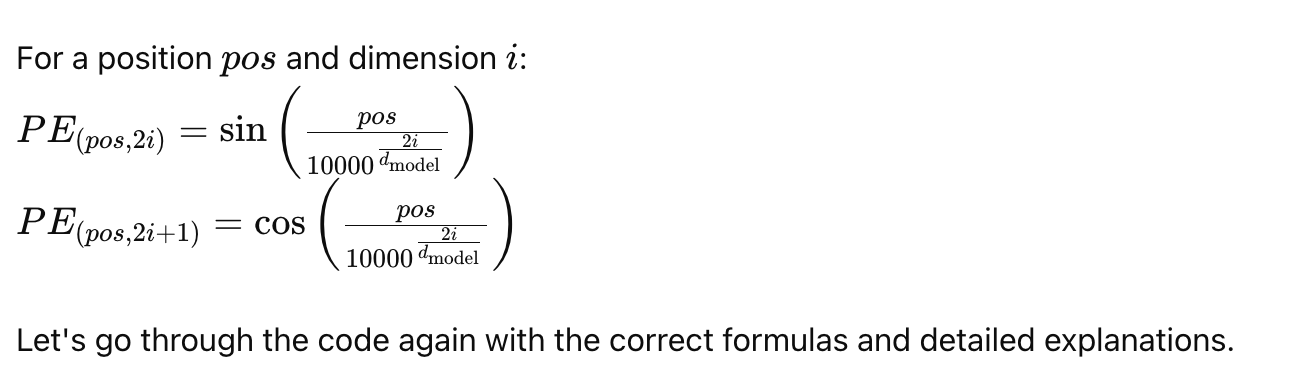

In [34]:
import torch
import math

def get_positional_embeddings(max_seq_length, embedding_size):
    # Create position indices
    position = torch.arange(0, max_seq_length).unsqueeze(1)
    print("position", position)

    # Calculate the divisor term
    div_term_1 = -math.log(10000.0) / embedding_size
    print("div_term_1", div_term_1)

    # Create the exponent term
    div_term_2 = torch.arange(0, embedding_size, 2)
    print("div_term2", div_term_2, div_term_2.shape)

    # Calculate the divisor term
    div_term = torch.exp(div_term_2 * div_term_1)
    print("div_term", div_term)

    # Initialize the positional encoding tensor
    positional_encoding = torch.zeros(max_seq_length, embedding_size)
    print("positional_encoding", positional_encoding)

    # Apply sine to even indices and cosine to odd indices
    positional_encoding[:, 0::2] = torch.sin(position * div_term)
    positional_encoding[:, 1::2] = torch.cos(position * div_term)
    print("positional_encoding", positional_encoding[:, 0::2], positional_encoding[:, 1::2], positional_encoding.shape)

    # Reshape the positional encoding tensor
    positional_encoding = positional_encoding.unsqueeze(1)
    print("positional_encoding", positional_encoding, positional_encoding.shape)

    return positional_encoding


In [35]:
max_seq_length = len(sentence.split())
positional_encodings = get_positional_embeddings(max_seq_length, embedding_size)

position tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8]])
div_term_1 -0.28782313662425574
div_term2 tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]) torch.Size([16])
div_term tensor([1.0000e+00, 5.6234e-01, 3.1623e-01, 1.7783e-01, 1.0000e-01, 5.6234e-02,
        3.1623e-02, 1.7783e-02, 1.0000e-02, 5.6234e-03, 3.1623e-03, 1.7783e-03,
        1.0000e-03, 5.6234e-04, 3.1623e-04, 1.7783e-04])
positional_encoding tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Create Decoder block

In [36]:
class FeedForwardNetwork(nn.Module):
  def __init__(self, embedding_size, hidden_dims):
    super(FeedForwardNetwork,self).__init__()

    self.linear1 = nn.Linear(embedding_size, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, embedding_size)

  def forward(self,x):
    out = self.linear1(x)
    out = F.relu(out)
    out = self.linear2(out)
    return out

In [37]:
class DecoderBlock(nn.Module):
  def __init__(self, embedding_size, hidden_dims, attention_heads, dropout = 0.1):
    super(DecoderBlock,self).__init__()

    self.attention = nn.MultiheadAttention(embedding_size,attention_heads,dropout=dropout)
    self.norm1 = nn.LayerNorm(embedding_size)
    self.norm2 = nn.LayerNorm(embedding_size)
    self.dropout = nn.Dropout(dropout)
    self.feed = FeedForwardNetwork(embedding_size, hidden_dims)

  def forward(self, x, mask):
    attn_out, _ = self.attention(x, x, x, attn_mask=mask)
    out = x + self.dropout(attn_out)
    out = self.norm1(out)

    feed_out = self.feed(x)
    out = out + self.dropout(feed_out)
    out = self.norm2(out)
    return out


In [38]:
class PositionalEncoding(nn.Module):
  def __init__(self, embedding_size, dropout = 0.1, seq_length = 5000):
    super (PositionalEncoding, self).__init__()

    self.dropout = nn.Dropout(p=dropout)

    position = torch.arange(0,seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0,embedding_size,2).float() * (-math.log(10000.0)/embedding_size))
    positional_encoding = torch.zeros(seq_length, embedding_size)
    positional_encoding[:,0::2] = torch.sin(position * div_term)
    positional_encoding[:,1::2] = torch.cos(position * div_term)

    positional_encoding = positional_encoding.unsqueeze(0).transpose(0,1)
    self.register_buffer("positional_encoding",positional_encoding)

  def forward(self, x):
    x = x + self.positional_encoding[:x.size(0), :]
    return self.dropout(x)


torch.triu(torch.ones(sz, sz)) creates an upper triangular matrix of ones with shape (sz, sz). Comparing this to 1 results in a boolean matrix where the upper triangle (including the diagonal) is True and the lower triangle is False. This is also printed along with its shape. Then the upper triangular matrix is transposed, and the result is stored in pt. A transposed upper triangular matrix is created again and assigned to mask.
mask.float() converts the boolean matrix to a float matrix with 1.0 for True and 0.0 for False.
masked_fill(mask == 0, float('-inf')) sets all the 0.0 values (from False positions) to -inf.
masked_fill(mask == 1, float(0.0)) ensures that all 1.0 values (from True positions) remain 0.0.

In [39]:
def generate_mask(sz):
    """Generate a mask to prevent attention to future positions."""
    print(torch.ones(sz, sz),torch.ones(sz, sz).shape)
    print(torch.triu(torch.ones(sz, sz)) == 1,(torch.triu(torch.ones(sz, sz)) == 1).shape)
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    print("mask",mask,mask.shape)
    print(mask.float())
    print(mask.float().masked_fill(mask == 0, float('-inf')))

    masking = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return masking

In [40]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_dims, attention_heads, no_blocks, dropout):
    super(Decoder,self).__init__()

    self.embeddings = nn.Embedding(vocab_size, embedding_size)
    self.positional_embeddings = PositionalEncoding(embedding_size, dropout)
    self.layers = nn.ModuleList(
        [
            DecoderBlock(embedding_size, hidden_dims, attention_heads, dropout)
            for _ in range(no_blocks)
        ]
    )
    self.linear = nn.Linear(embedding_size, vocab_size)
    self.softmax = nn.LogSoftmax(dim=-1)

  def forward(self, x):
    out = self.embeddings(x)
    print(out.shape)
    out = self.positional_embeddings(out)
    print(out.shape)
    mask = generate_mask(out.size(0))
    print("masking",mask,mask.shape)

    for layer in self.layers:
      out = layer(out, mask)

    out = self.linear(out)
    out = self.softmax(out)

    return out



tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]) torch.Size([5, 5])
tensor([[ True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True]]) torch.Size([5, 5])
mask tensor([[ True, False, False, False, False],
        [ True,  True, False, False, False],
        [ True,  True,  True, False, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True]]) torch.Size([5, 5])
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])
tensor([[1., -inf, -inf, -inf, -inf],
        [1., 1., -inf, -inf, -inf],
        [1., 1., 1., -inf, -inf],
        [1., 1., 1., 1., -inf],
        [1., 1., 1., 1., 1.]])


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1354: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1355: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


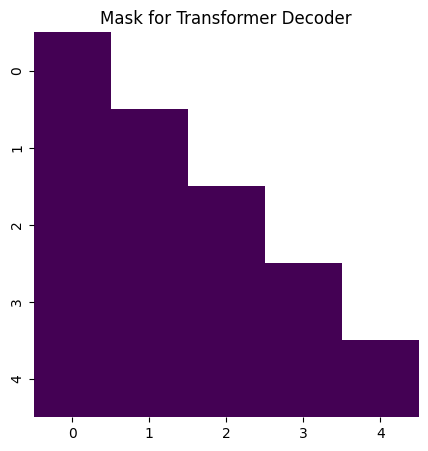

In [41]:
mask = generate_mask(sz=5)

plt.figure(figsize=(5,5))
seaborn.heatmap(mask, cmap="viridis", cbar=False, square=True)
plt.title("Mask for Transformer Decoder")
plt.show()


In [42]:
vocab_size = 5000
embedding_size = 512
hidden_dims = 2*embedding_size
attention_heads = 8
no_blocks = 8
dropout = 0.1

input_tensor = torch.randint(0,vocab_size,(2,5))
print("input_tensor",input_tensor.shape)
model = Decoder(vocab_size, embedding_size, hidden_dims, attention_heads, no_blocks, dropout)
embeddings = model(input_tensor)
print("output_tensor", embeddings)

# To get the predicted word indices, we can use the `argmax` function
predicted_indices = embeddings.argmax(dim=-1)

# Now `predicted_indices` is a tensor of shape (sequence_length, batch_size) containing the predicted word indices
print(predicted_indices)  # Should print torch.Size([context_length, batch_size])



input_tensor torch.Size([2, 5])
torch.Size([2, 5, 512])
torch.Size([2, 5, 512])
tensor([[1., 1.],
        [1., 1.]]) torch.Size([2, 2])
tensor([[ True,  True],
        [False,  True]]) torch.Size([2, 2])
mask tensor([[ True, False],
        [ True,  True]]) torch.Size([2, 2])
tensor([[1., 0.],
        [1., 1.]])
tensor([[1., -inf],
        [1., 1.]])
masking tensor([[0., -inf],
        [0., 0.]]) torch.Size([2, 2])
output_tensor tensor([[[-7.1770, -8.9692, -9.5503,  ..., -9.2224, -8.9407, -8.5528],
         [-8.4310, -8.9276, -9.8147,  ..., -9.3275, -8.2354, -8.9706],
         [-9.0075, -8.8613, -8.8674,  ..., -8.4588, -8.9950, -8.6003],
         [-9.0016, -8.8442, -9.4267,  ..., -8.5305, -8.7607, -8.9248],
         [-8.8310, -8.5856, -8.9397,  ..., -8.2833, -8.5560, -9.2832]],

        [[-7.8716, -9.0912, -9.7896,  ..., -9.5076, -8.6001, -8.8430],
         [-8.0270, -8.8364, -9.3560,  ..., -9.4766, -7.9776, -9.6512],
         [-9.0332, -9.2287, -8.6110,  ..., -8.6338, -8.3675, -8.2089

In [43]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 21,947,272 trainable parameters


In [44]:
print(embeddings.shape)
print(embeddings[0,0,:].shape)

torch.Size([2, 5, 5000])
torch.Size([5000])


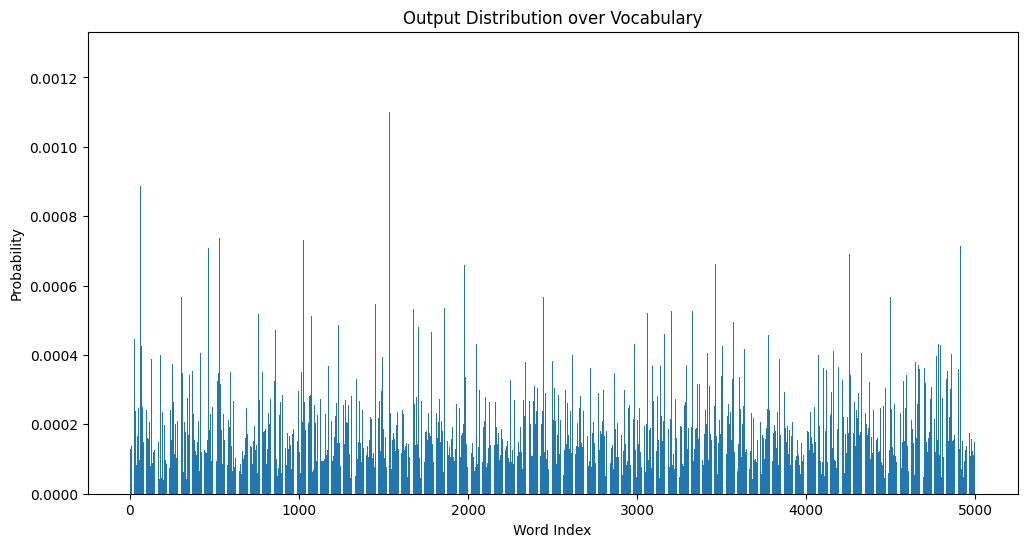

In [45]:
# Convert the log probabilities to probabilities
distribution = torch.exp(embeddings[0, 0, :])

# Convert the output tensor to numpy array
distribution = distribution.detach().numpy()

# Now plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(np.arange(vocab_size), distribution)
plt.xlabel("Word Index")
plt.ylabel("Probability")
plt.title("Output Distribution over Vocabulary")
plt.show()

In [46]:
vocab_size     = 10000
d_model        = 2048
num_heads      = 1
ff_hidden_dim  = 4*d_model
dropout        = 0.1
num_layers     = 10
context_length = 100
batch_size     = 1

input_tensor = torch.randint(0,vocab_size,(context_length, batch_size))
print("input_tensor",input_tensor.shape)
model = Decoder(vocab_size, embedding_size, hidden_dims, attention_heads, no_blocks, dropout)
embeddings = model(input_tensor)
print("output_tensor", embeddings.shape)

# To get the predicted word indices, we can use the `argmax` function
predicted_indices = embeddings.argmax(dim=-1)

# Now `predicted_indices` is a tensor of shape (sequence_length, batch_size) containing the predicted word indices
print(predicted_indices.shape)  # Should print torch.Size([context_length, batch_size])



input_tensor torch.Size([100, 1])
torch.Size([100, 1, 512])
torch.Size([100, 1, 512])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]) torch.Size([100, 100])
tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [False,  True,  True,  ...,  True,  True,  True],
        [False, False,  True,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ..., False,  True,  True],
        [False, False, False,  ..., False, False,  True]]) torch.Size([100, 100])
mask tensor([[ True, False, False,  ..., False, False, False],
        [ True,  True, False,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True, False, False],
  

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 27,072,272 trainable parameters


In [48]:
print(embeddings.shape)
print(embeddings[0,0,:].shape)

torch.Size([100, 1, 10000])
torch.Size([10000])


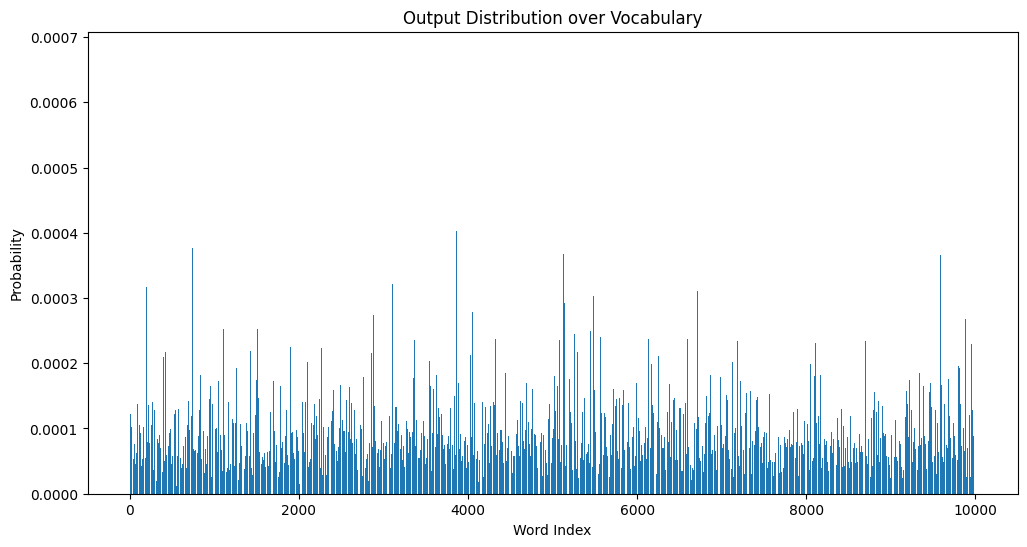

In [49]:
# Convert the log probabilities to probabilities for the first sequence in the batch and the first position in the sequence
distribution = torch.exp(embeddings[0, 0, :])

# Convert the output tensor to numpy array
distribution = distribution.detach().numpy()

# Now plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(np.arange(vocab_size), distribution)
plt.xlabel("Word Index")
plt.ylabel("Probability")
plt.title("Output Distribution over Vocabulary")
plt.show()

In [50]:
context_length = 50
batch_size     = 10
embedding_size = 100
attention_heads = 10
hidden_dims = 4 * embedding_size
dropout = 0.1
no_blocks = 4


vocab = ["of", "in", "to", "for", "with", "on", "at", "from", "by", "about", "as", "into", "like", "through", "after", "over", "between", "out", "against", "during", "without", "before", "under", "around", "among"]
vocab_size = len(vocab)

word2id = {word:id for id, word in enumerate(vocab)}
id2word = {id:word for id, word in enumerate(vocab)}
print(word2id)
print(id2word)

model = Decoder(vocab_size, embedding_size, hidden_dims, attention_heads, no_blocks, dropout)
sequence = ["of", "to", "under", "about", "after", "like"][:context_length]
input_tensor = torch.tensor([[word2id[word] for word in sequence]])
# print(sequence,input_tensor,input_tensor.shape)

words = []
for i in range(20):
  embeddings = model(input_tensor)
  predicted_indices = embeddings.argmax(dim=-1)
  predicted_indices = predicted_indices[0,-1]
  predicted_word = id2word[predicted_indices.item()]
  words.append(predicted_word)
  input_tensor = torch.cat([input_tensor, predicted_indices.unsqueeze(0).unsqueeze(0)], dim=-1)  # Append the predicted word to the input
  time.sleep(0.75)  # Pause for 1 second

words

{'of': 0, 'in': 1, 'to': 2, 'for': 3, 'with': 4, 'on': 5, 'at': 6, 'from': 7, 'by': 8, 'about': 9, 'as': 10, 'into': 11, 'like': 12, 'through': 13, 'after': 14, 'over': 15, 'between': 16, 'out': 17, 'against': 18, 'during': 19, 'without': 20, 'before': 21, 'under': 22, 'around': 23, 'among': 24}
{0: 'of', 1: 'in', 2: 'to', 3: 'for', 4: 'with', 5: 'on', 6: 'at', 7: 'from', 8: 'by', 9: 'about', 10: 'as', 11: 'into', 12: 'like', 13: 'through', 14: 'after', 15: 'over', 16: 'between', 17: 'out', 18: 'against', 19: 'during', 20: 'without', 21: 'before', 22: 'under', 23: 'around', 24: 'among'}
torch.Size([1, 6, 100])
torch.Size([1, 6, 100])
tensor([[1.]]) torch.Size([1, 1])
tensor([[True]]) torch.Size([1, 1])
mask tensor([[True]]) torch.Size([1, 1])
tensor([[1.]])
tensor([[1.]])
masking tensor([[0.]]) torch.Size([1, 1])
torch.Size([1, 7, 100])
torch.Size([1, 7, 100])
tensor([[1.]]) torch.Size([1, 1])
tensor([[True]]) torch.Size([1, 1])
mask tensor([[True]]) torch.Size([1, 1])
tensor([[1.]])
t

['against',
 'before',
 'by',
 'after',
 'in',
 'during',
 'during',
 'for',
 'during',
 'during',
 'in',
 'during',
 'for',
 'before',
 'against',
 'before',
 'by',
 'during',
 'in',
 'before']

In [51]:
print(embeddings.shape)
print(embeddings[0,0,:].shape)

torch.Size([1, 25, 25])
torch.Size([25])


In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained models and tokenizers
tokenizer_small = GPT2Tokenizer.from_pretrained("gpt2")
model_small = GPT2LMHeadModel.from_pretrained("gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
prompt = "This is a MOOC about large language models, I have only just started, but already"


In [5]:
# We use the tokenizer to convert the prompt into a format that the model can understand. In this case,
# it converts the string into a sequence of token IDs, which are numbers that represent each word or subword in the string.
inputs_small = tokenizer_small.encode(prompt, return_tensors='pt')

# Create an attention mask. This is a sequence of 1s and 0s where 1s indicate that the corresponding token should
# be attended to and 0s indicate that the token should be ignored. Here, all tokens should be attended to.
attention_mask_small = torch.ones(inputs_small.shape, dtype=torch.long)

# Get the ID of the special end-of-sequence (EOS) token from the tokenizer. This token indicates the end of a sequence.
pad_token_id_small = tokenizer_small.eos_token_id

# Print the initial prompt. The 'end' argument specifies what to print at the end (default is newline, but we want space).
# 'flush' argument ensures that the output is printed immediately.
print(prompt, end=" ", flush=True)
print(inputs_small, attention_mask_small,pad_token_id_small)

This is a MOOC about large language models, I have only just started, but already tensor([[ 1212,   318,   257, 13070,  4503,   546,  1588,  3303,  4981,    11,
           314,   423,   691,   655,  2067,    11,   475,  1541]]) tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]) 50256


In [6]:
# We're going to generate 25 words
for _ in range(25):

    # Generate the next part of the sequence. 'do_sample=True' means to sample from the distribution of possible next tokens
    # rather than just taking the most likely next token. 'pad_token_id' argument is to tell the model what token to use if it
    # needs to pad the sequence to a certain length.
    outputs_small = model_small.generate(inputs_small, max_length=inputs_small.shape[-1]+1, do_sample=True, pad_token_id=pad_token_id_small,
                                         attention_mask=attention_mask_small)

    # The generated output is a sequence of token IDs, so we use the tokenizer to convert these back into words.
    generated_word = tokenizer_small.decode(outputs_small[0][-1])

    # Print the generated word, followed by a space. We use 'end' and 'flush' arguments as before.
    print(generated_word, end=' ', flush=True)

    # Append the generated token to the input sequence for the next round of generation. We have to add extra dimensions
    # to the tensor to match the shape of the input tensor (which is 2D: batch size x sequence length).
    inputs_small = torch.cat([inputs_small, outputs_small[0][-1].unsqueeze(0).unsqueeze(0)], dim=-1)

    # Extend the attention mask for the new token. Like before, it should be attended to, so we add a 1.
    attention_mask_small = torch.cat([attention_mask_small, torch.ones((1, 1), dtype=torch.long)], dim=-1)

    # We pause for 0.7 seconds to make the generation more readable.
    time.sleep(0.7)

# Finally, print a newline and a completion message.
print("\nGPT-2 Small completed.")

 had  the  tools  to  learn .  You 'll  just  have  to  find  an  online  group ,  find  the  topic  as  fast  as  your  eyes  can 
GPT-2 Small completed.


In [7]:
tokenizer_large = GPT2Tokenizer.from_pretrained("gpt2-XL")
model_large = GPT2LMHeadModel.from_pretrained("gpt2-XL")


In [8]:
# Generate text with GPT-2 XL
inputs_large = tokenizer_large.encode(prompt, return_tensors="pt")

# Add in the attention mask and pad token id
attention_mask_large = torch.ones(inputs_large.shape, dtype=torch.long)  # Creating a mask of ones with the same shape as inputs
pad_token_id_large = tokenizer_large.eos_token_id  # Get the eos_token_id from the tokenizer

print(prompt, end=" ", flush=True)
for _ in range(25):  # Generate 25 words
    outputs_large = model_large.generate(inputs_large, max_length=inputs_large.shape[-1]+1, do_sample=True, pad_token_id=pad_token_id_large,
                                         attention_mask=attention_mask_large)
    generated_word = tokenizer_large.decode(outputs_large[0][-1])
    print(generated_word, end=" ", flush=True)
    inputs_large = torch.cat([inputs_large, outputs_large[0][-1].unsqueeze(0).unsqueeze(0)], dim=-1)
    attention_mask_large = torch.cat([attention_mask_large, torch.ones((1, 1), dtype=torch.long)], dim=-1)
    time.sleep(0.7)
print("\nGPT-2 XL completed.")



This is a MOOC about large language models, I have only just started, but already  you 'll  see  things  like  " the ore ms "  about  " poly morph ism ";  lots  of  the  lessons  are  quite  dry ,  with 
GPT-2 XL completed.
